### Bayesian Methods - Bayesian Regression

##### 1. Bayesian Polynomial Regression

The temperature of a town in Sweden over one year is hypothesised to be able of being modelled as a quadratic polynomial. The regression model is described as:
$$
t_i = w_0 + w_1 x + w_2 x^2 + \varepsilon_i,~~ \varepsilon_i \overset{\text{iid}}{\sim} N(0, \sigma^2) ~~ \forall i \in \{1,\ldots,|D|\}
$$


In [7]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['science', 'notebook', 'grid'])

In [23]:
df = pd.read_csv('data/TempLambohov.txt', delimiter='   ', engine='python')

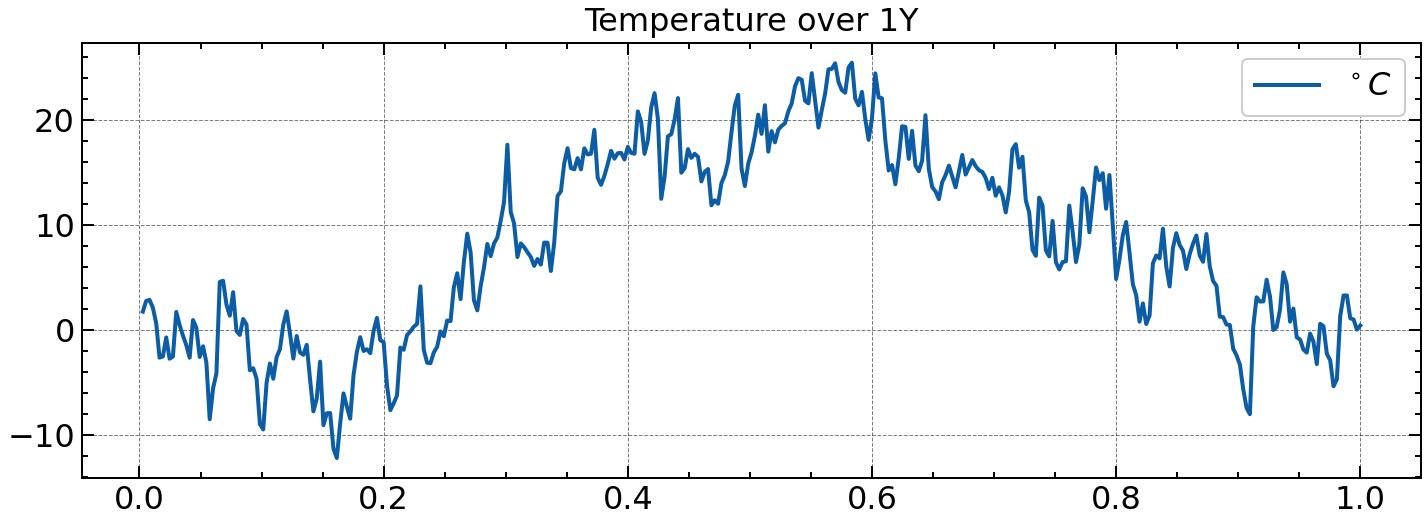

In [22]:
fig, ax = plt.subplots()

ax.plot(df['time'], df['temp'], label='$^\circ C$')
ax.set_title('Temperature over 1Y')
ax.legend()

fig.set_size_inches(12, 4)
plt.show()